In [1]:
# import packages

import pickle, pprint
import numpy as np
import collections
import sys
sys.path.insert(0, '../cell_soap/')
from cell_describe import node, edge, cell, colony, data

pkl_file = open('zo1_graph_timelapse_sample_v2.pkl','rb')
data1 = pickle.load(pkl_file)

# Load data structure at specified time

In [2]:
#Time step , checked - > t = 12, cut = 4
t = 18
V = data(data1, t)

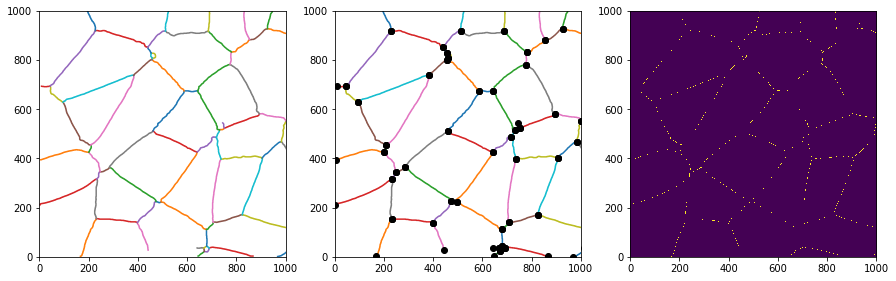

In [3]:
# Plot 
import matplotlib.pyplot as plt
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))
V.plot(ax, "edge", None)
V.plot(ax1, "edge_and_node", None)
V.plot(ax2, "image", None)

# Clean up overlapping nodes with small cutoff

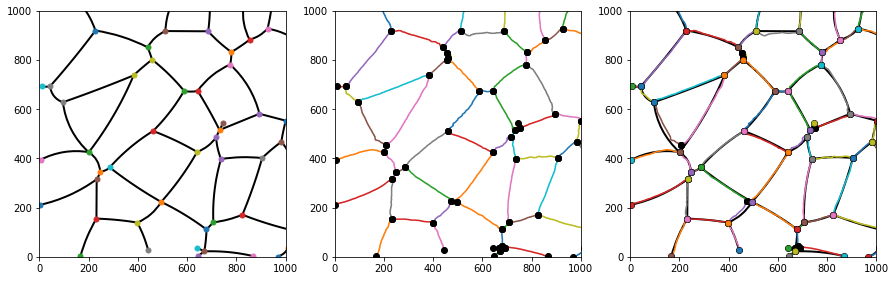

In [7]:
# Cutoff
cutoff = 30
nodes, edges = V.post_processing(cutoff, None)
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

V.plot(ax1, "edge_and_node", None)
V.plot(ax2, "edge_and_node", None)

for a in (ax, ax2):
    a.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
    [e.plot(a, lw = 2 ) for e in edges]
    [n.plot(a, markersize = 10) for n in nodes]


In [8]:
# Check repeats
print([item for item, count in collections.Counter(nodes).items() if count > 1])
print([item for item, count in collections.Counter(edges).items() if count > 1])

[]
[]


In [9]:
edges[0].radius

65.96818473864619

# Find cells

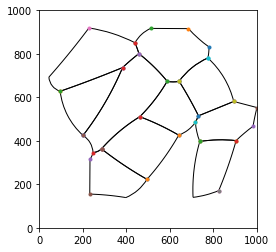

In [10]:
# Find cells

cells = []
max_iter = 100

for e in edges:
    cell = e.which_cell(edges, 1, max_iter)
    check = 0
    if cell != []:
        for c in cells:
            if set(cell.edges) == set(c.edges):
                check = 1
        if check == 0:
            cells.append(cell)

    cell = e.which_cell(edges, 0, max_iter)
    check = 0
    if cell != []:
        for c in cells:
            if set(cell.edges) == set(c.edges):
                check = 1
        if check == 0:
            cells.append(cell)

fig, ax = plt.subplots(1,1)
ax.set_aspect(1)
ax.set(xlim = [0,1000], ylim = [0,1000])
[c.plot(ax) for c in cells]
plt.show()

# Calculate tension and pressure

In [11]:
# Define colony and calculate tension. Then use that to find pressure

from cell_describe import colony 

edges2 = [e for e in edges if e.radius is not None]
col1 = colony(cells, edges, nodes)

# A and B are the matrices. Tensions and pressures are values for each edge and cell respectively 

tensions, P_T = col1.calculate_tension()

../cell_soap/cell_describe.py:583: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.245746e-19
  x = linalg.solve(R2, y) # Solve Rx=y


In [12]:
pressures, P_P = col1.calculate_pressure(tensions)

In [13]:
tensions

array([62., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.])

AttributeError: Unknown property edgecolor

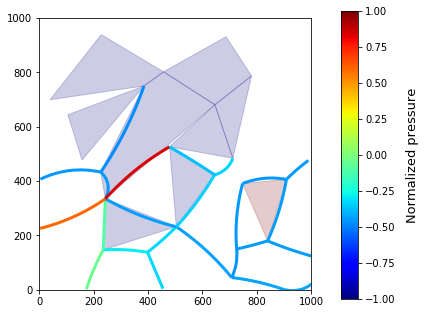

In [14]:
# plot tension and pressures on a single plot

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.colors import Normalize
import matplotlib as mpl

# Get edges from colony
edges2 = col1.tot_edges
nodes2 = col1.nodes
# edges2 = edges
# nodes2 = nodes
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


# Normalize pressures and tensions

min_t = min(tensions)
max_t = max(tensions)

def norm(tensions):
    return (tensions - min_t) / float(max_t - min_t)
    #return (tensions - np.mean(tensions))/float(np.std(tensions))

new = norm(tensions)

min_p = min(pressures)
max_p = max(pressures)

def norm(pressures):
    #return (pressures - min_p) / float(max_p - min_p)
    return (pressures - np.mean(pressures))/float(np.std(pressures))

new2 = norm(pressures)

# Plot pressures

for j, c in enumerate(cells):
    x = [n.loc[0] for n in c.nodes]
    y = [n.loc[1] for n in c.nodes]
    plt.fill(x, y, c= cm.jet(new2[j]), alpha = 0.2)

sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=-1, vmax=1))
# fake up the array of the scalar mappable. 
sm._A = []

cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cl = plt.colorbar(sm, cax = cbaxes)  
cl.set_label('Normalized pressure', fontsize = 13, labelpad = 10)


# # Plot tensions

for j, an_edge in enumerate(edges2):
    an_edge.plot(ax, edgecolor = cm.jet(new[j]), lw = 3)

sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. 
sm._A = []

cbaxes = fig.add_axes([0.13, 0.1, 0.03, 0.8])
cl = plt.colorbar(sm, cax = cbaxes)
cl.set_label('Normalized tension', fontsize = 13, labelpad = -60)

ax.set(xlim=[0,1000], ylim=[0, 1000], aspect = 1)
ax.set_title('Colony at time -> %d' %t, fontsize = 15)

# Check mean values of tension and pressure

# Should be 1
print('Mean value of tension is -> ', np.mean(tensions))

# Should be 0
print('Mean value of pressure is -> ', np.mean(pressures))

# Check condition numbers 
# Should be small 

print('Condition number for tension matrix is  -> ', np.linalg.cond(P_T))
print('Condition number for Pressure matrix is  -> ', np.linalg.cond(P_P))

In [12]:
new

array([0.38833823, 0.39156722, 0.59514077, 0.27876606, 0.31968698,
       0.29961833, 0.39489323, 0.29610541, 0.34010232, 0.4278769 ,
       0.39848747, 0.43400988, 0.42737419, 0.39201686, 0.52725965,
       0.33658933, 0.33316797, 0.3343481 , 0.27369673, 0.49818829,
       0.3405612 , 0.46061497, 0.42850608, 0.68270198, 0.60665261,
       0.58264492, 0.48665011, 0.32143503, 0.09972624, 0.36499574,
       0.39960924, 0.3935299 , 0.33143778, 0.32175986, 0.43578598,
       0.65157689, 0.44980355, 0.69597586, 0.40487458, 0.41800122,
       0.        , 0.28584899, 0.46586444, 0.42817984, 0.4373975 ,
       0.39228123, 0.47735578, 0.38841499, 0.24030475, 0.38229882,
       0.41387914, 0.35473951, 0.12211813, 0.45218914, 0.43216229,
       0.40447416, 0.41733554, 0.55310875, 0.42594089, 0.39213424,
       0.45382609, 0.7287483 , 0.84822859, 0.35222601, 1.        ,
       0.48188124, 0.88297691, 0.8825774 , 0.55845264, 0.53935622,
       0.42235442, 0.48180689, 0.50955183, 0.54981314, 0.42161